# <CENTER>EMOTIONSONIC - A SPEECH EMOTION RECOGNITION APPLICATION

## IMPORT NECESSARY LIBRARIES

In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objs as go

import librosa
import librosa.display
from IPython.display import Audio

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore") 

## DATA COLLECTION

In [2]:
def create_combined_dataset():
    
    # RAVDESS
    ravdess_path = "../datasets/ser/all/Ravdess/audio_speech_actors_01-24"
    actor_folders = os.listdir(ravdess_path)

    file_emotion = []
    file_path = []

    for actor_folder in actor_folders:
        actor_path = os.path.join(ravdess_path, actor_folder)
        actor_files = os.listdir(actor_path)

        for file in actor_files:
            part = file.split('.')[0]
            part = part.split('-')
            file_emotion.append(int(part[2]))
            file_path.append(os.path.join(actor_path, file))

    emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
    path_df = pd.DataFrame(file_path, columns=['Path'])
    ravdess_df = pd.concat([emotion_df, path_df], axis=1)

    emotion_mapping = {
        1: 'neutral',
        2: 'calm',
        3: 'happy',
        4: 'sad',
        5: 'angry',
        6: 'fear',
        7: 'disgust',
        8: 'surprise'
    }
    ravdess_df['Emotions'] = ravdess_df['Emotions'].map(emotion_mapping)
    print('\n RAVDESS SHAPE : ',ravdess_df.shape)
    
    
    # CREMA-D
    crema_path = "../datasets/ser/all/Crema"
    crema_directory_list = os.listdir(crema_path)

    file_emotion = []
    file_path = []

    for file in crema_directory_list:
        file_path.append(crema_path + '/' + file)
        part = file.split('_')
        if part[2] == 'SAD':
            file_emotion.append('sad')
        elif part[2] == 'ANG':
            file_emotion.append('angry')
        elif part[2] == 'DIS':
            file_emotion.append('disgust')
        elif part[2] == 'FEA':
            file_emotion.append('fear')
        elif part[2] == 'HAP':
            file_emotion.append('happy')
        elif part[2] == 'NEU':
            file_emotion.append('neutral')
        else:
            file_emotion.append('Unknown')

    emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
    path_df = pd.DataFrame(file_path, columns=['Path'])
    crema_df = pd.concat([emotion_df, path_df], axis=1)
    print('\n CREMA-D SHAPE : ',crema_df.shape)
    
    
    # TESS
    tess_path = "../datasets/ser/all/Tess/"
    tess_directory_list = os.listdir(tess_path)

    file_emotion = []
    file_path = []

    for dir in tess_directory_list:
        directories = os.listdir(tess_path + dir)
        for file in directories:
            part = file.split('.')[0]
            part = part.split('_')[2]
            if part == 'ps':
                file_emotion.append('surprise')
            else:
                file_emotion.append(part)
            file_path.append(tess_path + dir + '/' + file)

    emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
    path_df = pd.DataFrame(file_path, columns=['Path'])
    tess_df = pd.concat([emotion_df, path_df], axis=1)
    print('\n TESS SHAPE : ',tess_df.shape)
    
    # SAVEE
    savee_path = "../datasets/ser/all/Savee/"
    savee_directory_list = os.listdir(savee_path)

    file_emotion = []
    file_path = []

    for file in savee_directory_list:
        file_path.append(savee_path + file)
        part = file.split('_')[1]
        ele = part[:-6]
        if ele == 'a':
            file_emotion.append('angry')
        elif ele == 'd':
            file_emotion.append('disgust')
        elif ele == 'f':
            file_emotion.append('fear')
        elif ele == 'h':
            file_emotion.append('happy')
        elif ele == 'n':
            file_emotion.append('neutral')
        elif ele == 'sa':
            file_emotion.append('sad')
        else:
            file_emotion.append('surprise')

    emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
    path_df = pd.DataFrame(file_path, columns=['Path'])
    savee_df = pd.concat([emotion_df, path_df], axis=1)
    print('\n SAVEE SHAPE : ',savee_df.shape)
    
    # concate all created datasets
    data_path = pd.concat([ravdess_df, crema_df, tess_df, savee_df], axis=0)
    data_path.to_csv("ser_data.csv", index=False)

    return data_path


ser_df = create_combined_dataset()
print('---'*20)
print('\n','TOTAL SER DATASET SHAPE : ',ser_df.shape)
print('\n',ser_df.head())


 RAVDESS SHAPE :  (1440, 2)

 CREMA-D SHAPE :  (7442, 2)

 TESS SHAPE :  (2800, 2)

 SAVEE SHAPE :  (480, 2)
------------------------------------------------------------

 TOTAL SER DATASET SHAPE :  (12162, 2)

   Emotions                                               Path
0  neutral  ../datasets/ser/all/Ravdess/audio_speech_actor...
1  neutral  ../datasets/ser/all/Ravdess/audio_speech_actor...
2  neutral  ../datasets/ser/all/Ravdess/audio_speech_actor...
3  neutral  ../datasets/ser/all/Ravdess/audio_speech_actor...
4     calm  ../datasets/ser/all/Ravdess/audio_speech_actor...


## VISUALIZING COUNT OF EACH EMOTIONS

In [3]:
emotion_counts = ser_df['Emotions'].value_counts().reset_index()
emotion_counts.columns = ['Emotion', 'Count']

colors = {
    'happy': '#ffea00',  # Gold
    'sad': '#1E90FF',    # Dodger Blue
    'angry': '#dc2f02',  # Tomato
    'fear': '#70e000',   # Sea Green
    'disgust': '#c77dff',# Dark Orchid
    'neutral': '#A9A9A9',# Dark Gray
    'surprise': '#FFA500',# Orange
    'calm': '#00CED1'    # Dark Turquoise
}

fig = px.pie(emotion_counts, names='Emotion', values='Count', title='Distribution of Emotions',
             color_discrete_sequence=[colors[emotion] for emotion in emotion_counts['Emotion']])
fig.update_traces(textinfo='percent+label', pull=[0.13]*8, textfont_size=15)
fig.show()

## VISUALIZING WAVEPLOT FOR AUDIO WITH FEW EMOTIONS

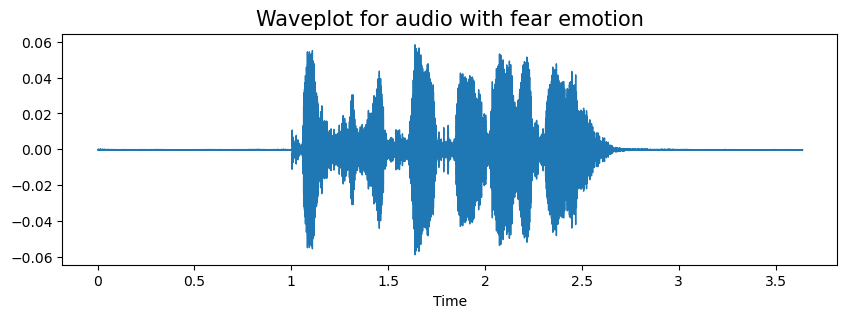

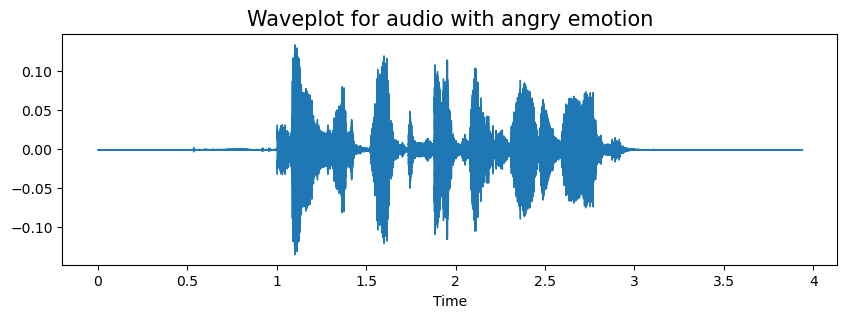

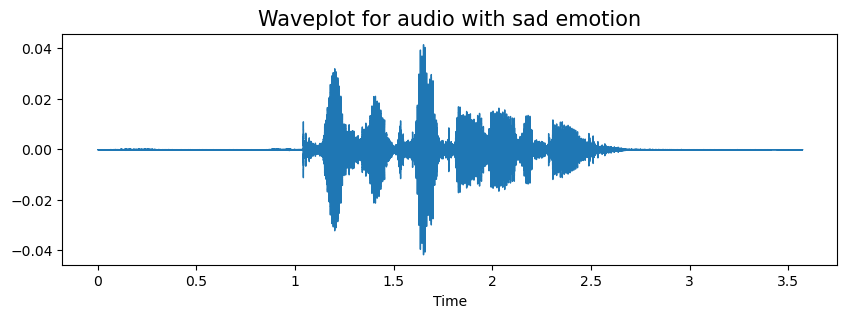

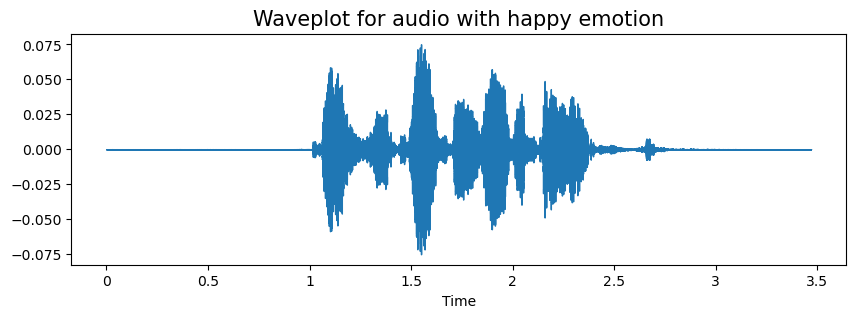

In [5]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

emotions = ['fear', 'angry', 'sad', 'happy']

for emotion in emotions:
    path = np.array(ser_df.Path[ser_df.Emotions == emotion])[1]
    data, sampling_rate = librosa.load(path)
    create_waveplot(data, sampling_rate, emotion)
    Audio(path)


## VISUALIZING SPECTROGRAM FOR AUDIO WITH FEW EMOTIONS

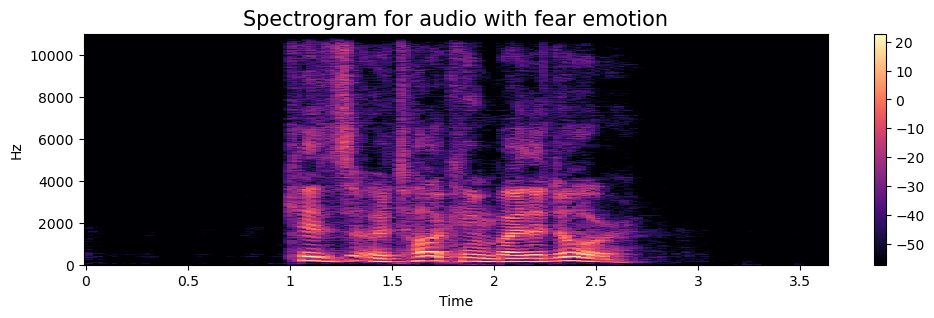

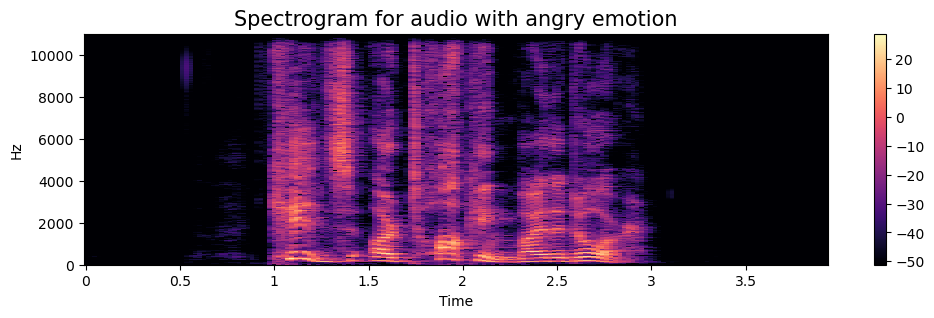

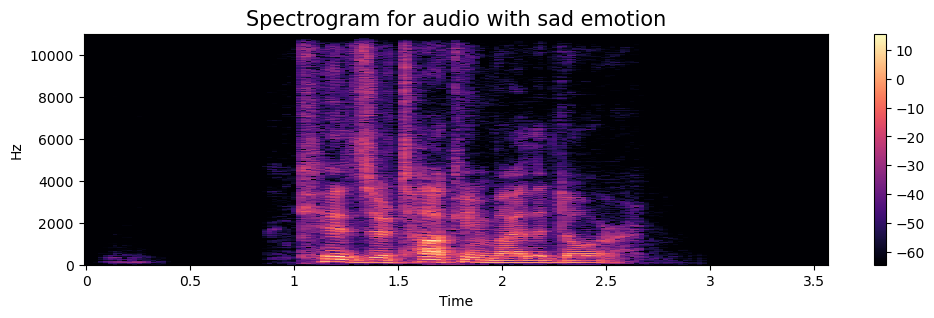

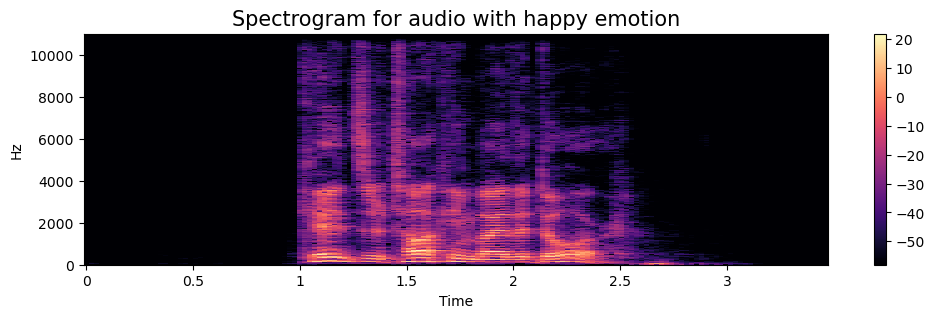

In [6]:
def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    plt.colorbar()
    
emotions = ['fear', 'angry', 'sad', 'happy']

for emotion in emotions:
    path = np.array(ser_df.Path[ser_df.Emotions == emotion])[1]
    data, sampling_rate = librosa.load(path)
    create_spectrogram(data, sampling_rate, emotion)
    Audio(path)
    

## VISUALIZING WAVEPLOT FOR AUGMENTED AUDIO 

In [4]:
def add_noise(data):
        noise_amp = 0.035 * np.random.uniform() * np.amax(data)
        return data + noise_amp * np.random.normal(size=data.shape[0])

def time_stretch(data, rate=0.8):
        return librosa.effects.time_stretch(data, rate=rate)

def shift_audio(data):
        shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
        return np.roll(data, shift_range)

def pitch_shift(data, pitch_steps=-2):
        return librosa.effects.pitch_shift(data, sr=sample_rate, n_steps=pitch_steps)

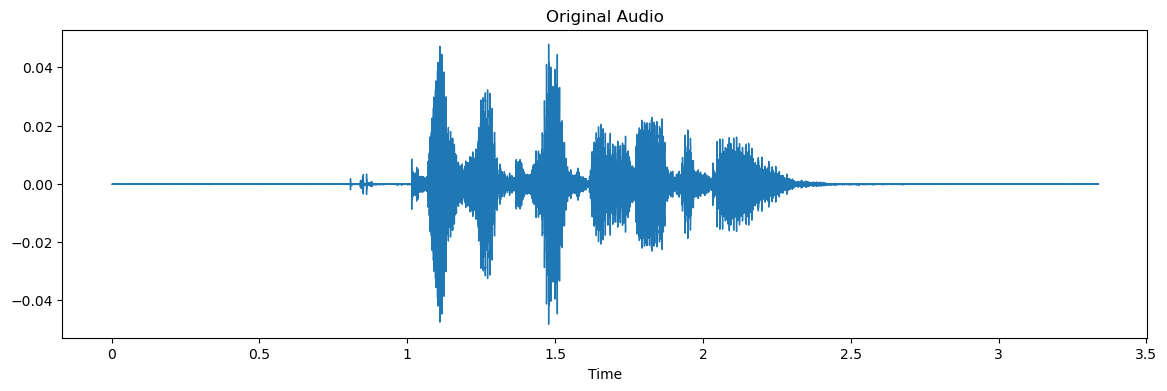

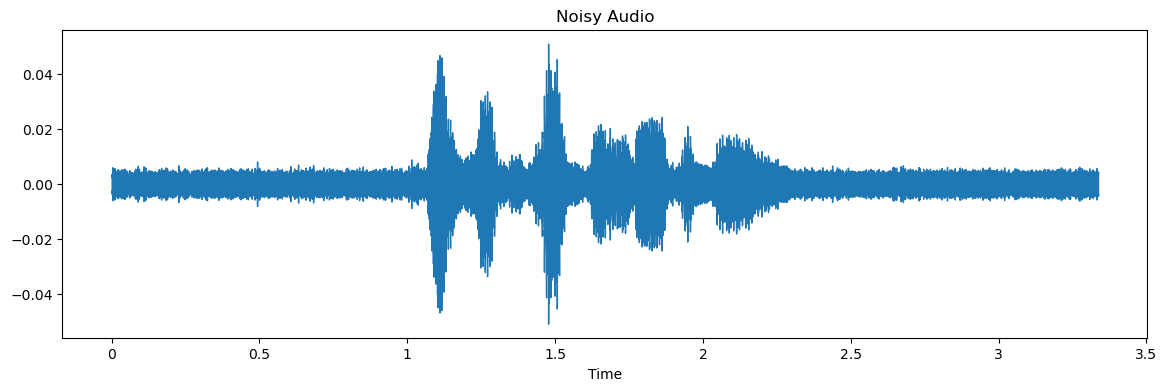

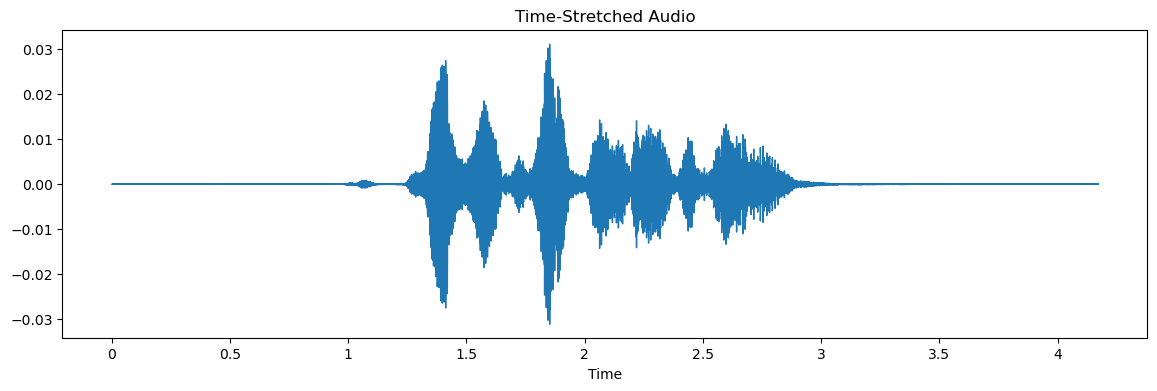

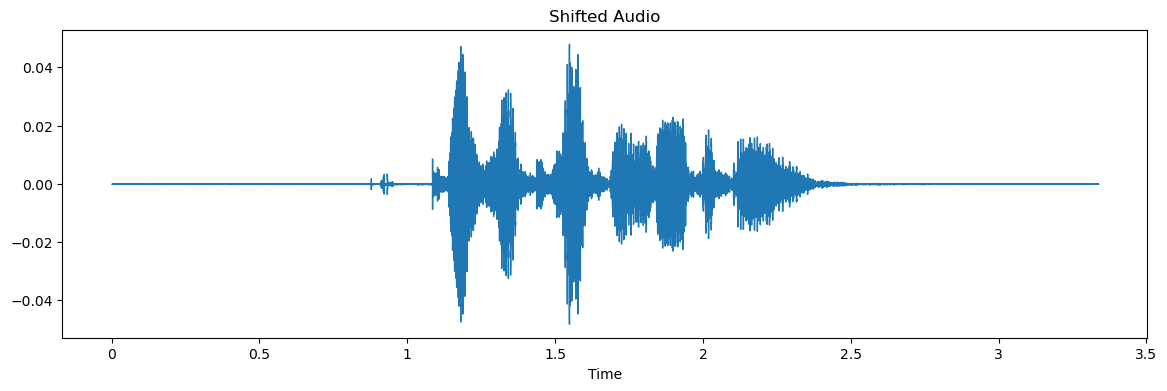

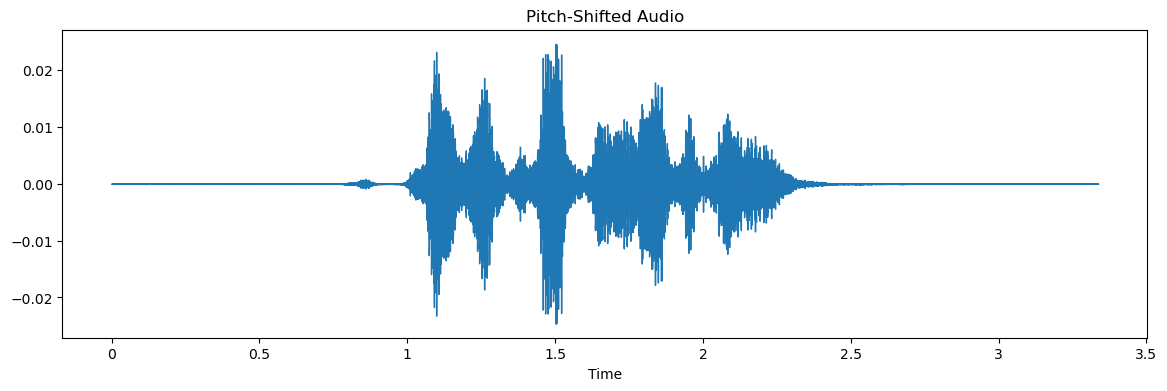

In [5]:
def apply_audio_processing(path, sample_rate):
    
    # Load audio data
    data, _ = librosa.load(path, sr=sample_rate)

    # Original audio
    plt.figure(figsize=(14, 4))
    librosa.display.waveshow(y=data, sr=sample_rate)
    plt.title('Original Audio')
    plt.show()
    Audio(data, rate=sample_rate)

    # Noise
    noisy_data = add_noise(data)
    plt.figure(figsize=(14, 4))
    librosa.display.waveshow(y=noisy_data, sr=sample_rate)
    plt.title('Noisy Audio')
    plt.show()
    Audio(noisy_data, rate=sample_rate)

    # Time Stretching
    stretched_data = time_stretch(data)
    plt.figure(figsize=(14, 4))
    librosa.display.waveshow(y=stretched_data, sr=sample_rate)
    plt.title('Time-Stretched Audio')
    plt.show()
    Audio(stretched_data, rate=sample_rate)

    # Shifting
    shifted_data = shift_audio(data)
    plt.figure(figsize=(14, 4))
    librosa.display.waveshow(y=shifted_data, sr=sample_rate)
    plt.title('Shifted Audio')
    plt.show()
    Audio(shifted_data, rate=sample_rate)

    # Pitch Shift
    pitched_data = pitch_shift(data)
    plt.figure(figsize=(14, 4))
    librosa.display.waveshow(y=pitched_data, sr=sample_rate)
    plt.title('Pitch-Shifted Audio')
    plt.show()
    Audio(pitched_data, rate=sample_rate)


path = np.array(ser_df.Path)[1] 
sample_rate = 45000
apply_audio_processing(path, sample_rate)


## DATA PREPROCESSING

#### EXTRACTING FEATURES 

In [6]:
def extract_features(data):
    # ZCR(Zero-Crossing Rate): Captures noisiness in the audio.
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft (Chroma Short-Time Fourier Transform): Represents pitch class distribution.
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    #MFCC (Mel-Frequency Cepstral Coefficients): Captures spectral characteristics.
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    #RMS (Root Mean Square Value): Measures overall loudness.
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram : Represents the power spectral density in the Mel frequency scale.
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

####  DATA AUGMENTATION 

In [7]:
def get_features(path, sample_rate):
    data, _ = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = add_noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2))  # stacking vertically
    
    # data with stretching and pitching
    new_data = time_stretch(data)
    data_stretch_pitch = pitch_shift(new_data)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3))  # stacking vertically
    
    return result

In [8]:
X, Y = [], []
for path, emotion in zip(ser_df.Path, ser_df.Emotions):
    features = get_features(path, sample_rate)  #sample_rate = 45000
    for ele in features:
        X.append(ele)
        # Appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

#### STORING EXTRACTED FEATURES FOR AUDIO INTO SER_FEATURES DATAFRAME

In [9]:
ser_features = pd.DataFrame(X)
ser_features['labels'] = Y
ser_features.to_csv('ser_features.csv', index=False)
ser_features.head()

0         1         2         3         4         5         6  \
0  0.321275  0.690409  0.749516  0.733207  0.687960  0.696087  0.702965   
1  0.328423  0.763701  0.808142  0.803417  0.761181  0.758278  0.753261   
2  0.152315  0.701026  0.693350  0.707351  0.680872  0.674664  0.725806   
3  0.293566  0.691314  0.706470  0.715819  0.671245  0.643935  0.677488   
4  0.274373  0.711557  0.750588  0.757999  0.702216  0.682284  0.714991   

          7         8         9        10        11        12          13  \
0  0.681044  0.716678  0.762029  0.781151  0.750590  0.733752 -661.215271   
1  0.705099  0.727977  0.758269  0.780249  0.770023  0.758866 -457.694039   
2  0.739314  0.752204  0.711985  0.661665  0.662803  0.743567 -721.283813   
3  0.652222  0.643890  0.696976  0.737874  0.736831  0.730840 -647.763794   
4  0.664970  0.651372  0.703355  0.736255  0.745174  0.736169 -552.987613   

          14        15         16         17         18         19        20  \
0  74.365273 -7.446282   7.263388 -10.747729 -16.072514  -8.645786 -3.125604   
1  30.470525  3.775679  -0.247245  -8.552715 -12.140954  -8.247932 -3.717554   
2  77.826309 -9.823673  13.707412  -8.600551 -10.423168 -14.703395 -1.481506   
3  72.551849 -9.665165  10.533235 -13.671365 -17.947145  -8.689536 -5.665305   
4  49.273365 -3.302888   4.146629 -12.368000 -16.001512  -8.116071 -5.143782   

         21        22         23        24        25        26        27  \
0 -1.251142  1.461861 -11.594028 -6.979894 -3.658406 -8.888730 -3.496704   
1  0.113528 -0.343202  -4.860758 -5.595247 -2.950167 -4.354331 -4.699297   
2 -6.692332  8.117769  -5.721896 -6.764703 -3.935575 -2.804415 -6.325693   
3  0.160181 -0.819807 -13.485491 -5.617886 -3.347259 -8.230683 -4.390243   
4 -0.395756 -2.532343 -11.361060 -6.823466 -3.963763 -7.408612 -5.810662   

         28         29        30         31        32        33            34  \
0 -8.880895  -1.179323 -5.514515  -5.744694 -1.923876  0.002988  2.310515e-07   
1 -3.048836  -1.962362 -2.299852  -3.369316 -2.172753  0.003537  3.819773e-05   
2 -2.539644 -10.326622  1.319299 -11.152114 -2.283246  0.001462  7.202915e-08   
3 -8.182556  -1.970643 -5.085821  -5.471970 -1.654655  0.003226  2.249134e-07   
4 -6.231081  -3.249189 -4.420261  -5.057805 -1.484768  0.003312  1.714622e-06   

             35        36        37        38        39        40        41  \
0  9.871779e-07  0.000011  0.000058  0.001329  0.006566  0.018517  0.017524   
1  3.443665e-05  0.000047  0.000099  0.001350  0.006570  0.018504  0.017566   
2  7.327945e-07  0.000008  0.000145  0.002579  0.006407  0.007067  0.003868   
3  1.416315e-06  0.000017  0.000078  0.001630  0.005174  0.016368  0.025757   
4  3.240960e-06  0.000017  0.000079  0.001643  0.005188  0.016326  0.025762   

         42        43        44        45        46        47        48  \
0  0.021447  0.014190  0.002161  0.002088  0.005103  0.018997  0.018099   
1  0.021667  0.014332  0.002239  0.002182  0.005204  0.019182  0.018316   
2  0.001966  0.000620  0.000529  0.001635  0.001883  0.001438  0.002249   
3  0.040290  0.022395  0.003136  0.001863  0.002832  0.010583  0.021540   
4  0.040281  0.022366  0.003128  0.001845  0.002813  0.010562  0.021559   

         49        50        51        52        53        54        55  \
0  0.010780  0.013794  0.014919  0.014680  0.006172  0.006104  0.004995   
1  0.010859  0.013819  0.015023  0.014826  0.006176  0.006101  0.004967   
2  0.006048  0.006242  0.001914  0.001902  0.001251  0.001119  0.002116   
3  0.018711  0.029706  0.029240  0.019719  0.005146  0.003289  0.004024   
4  0.018733  0.029758  0.029256  0.019744  0.005177  0.003297  0.004034   

         56        57        58        59        60        61        62  \
0  0.004055  0.005544  0.007385  0.012984  0.020730  0.039471  0.032230   
1  0.004085  0.005516  0.007390  0.013264  0.021016  0.039702  0.032432   
2  0.002683  0.005059  0.011469  0.010943  0.002719  0.001830  0.0012

#### BALANCING SER_FEATURES USING SMOTE AND STORING IN INTO BALANCED_SER_FEATURES DATAFRAME

In [10]:
colors = {
    'happy': '#ffea00',     # Gold
    'sad': '#1E90FF',       # Dodger Blue
    'angry': '#dc2f02',     # Tomato
    'fear': '#70e000',      # Sea Green
    'disgust': '#c77dff',   # Dark Orchid
    'neutral': '#A9A9A9',   # Dark Gray
    'surprise': '#FFA500',  # Orange
    'calm': '#00CED1'       # Dark Turquoise
}

fig = sp.make_subplots(rows=1, cols=2, subplot_titles=("Before SMOTE", "After SMOTE"))

before_smote_counts = ser_features['labels'].value_counts()
fig.add_trace(go.Bar(
    x=before_smote_counts,
    y=before_smote_counts.index,
    orientation='h',
    name='Before SMOTE',
    marker=dict(color=[colors[label] for label in before_smote_counts.index])
), row=1, col=1)

X = ser_features.drop(columns=['labels'])
y = ser_features['labels']

smote = SMOTE(sampling_strategy='auto', random_state=42)

X_resampled, y_resampled = smote.fit_resample(X, y)

balanced_ser_features = pd.DataFrame(X_resampled, columns=X.columns)
balanced_ser_features['labels'] = y_resampled

balanced_ser_features.to_csv('balanced_ser_features.csv', index=False)

after_smote_counts = balanced_ser_features['labels'].value_counts()
fig.add_trace(go.Bar(
    x=after_smote_counts,
    y=after_smote_counts.index,
    orientation='h',
    name='After SMOTE',
    marker=dict(color=[colors[label] for label in after_smote_counts.index])
), row=1, col=2)

fig.update_layout(
    title_text="Value Counts of Emotions (Before and After SMOTE)",
    xaxis=dict(title="Count"),
    yaxis=dict(title="Emotions"),
    xaxis2=dict(title="Count"),
    yaxis2=dict(title="Emotions"),
    showlegend=False,
)

fig.show()


#### SPLITTING VARIABLES INTO X (INDEPENDENT VARIABLES), Y (DEPENDENT VARIABLE)

In [14]:
X = balanced_ser_features.iloc[: ,:-1].values
Y = balanced_ser_features['labels'].values

#### SCALING INDEPENDENT VARIABLES

In [15]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

#### ENCODING THE DEPENDENT VARIABLE (EMOTIONS)

In [16]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

## MODEL BUILDING

#### TRAIN-TEST SPLIT

In [23]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True,test_size=0.2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((36921, 162), (36921, 8), (9231, 162), (9231, 8))

#### BUILDING A CNN MODEL 

In [24]:
model = Sequential()

#5 Convolutional Layers, 4 MaxPooling Layers, 2 Dropout Layers, 1 Flatten Layer, and 2 Dense Layers

model.add(Conv1D(500, 5, activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))  

model.add(Conv1D(350, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))  

model.add(Conv1D(225, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))  
model.add(Dropout(0.5))

model.add(Conv1D(164, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))  

model.add(Conv1D(90, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=2)) 

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(8, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 158, 500)          3000      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 79, 500)          0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 75, 350)           875350    
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 37, 350)          0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 33, 225)           393975    
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 16, 225)         

#### FITTING THE CNN MODEL

In [25]:
rlrp = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, min_lr=0.00001)

history = model.fit(x_train, y_train, epochs=50, batch_size=100, validation_data=(x_test, y_test), callbacks=[rlrp])

test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)

print(f"Test Accuracy: {test_accuracy*100:.2f}%")

Epoch 1/50
370/370 [==============================] - 156s 415ms/step - loss: 1.4983 - accuracy: 0.4377 - val_loss: 1.1654 - val_accuracy: 0.5547 - lr: 0.0010
Epoch 2/50
370/370 [==============================] - 147s 399ms/step - loss: 1.1427 - accuracy: 0.5711 - val_loss: 0.9961 - val_accuracy: 0.6237 - lr: 0.0010
Epoch 3/50
370/370 [==============================] - 143s 386ms/step - loss: 1.0342 - accuracy: 0.6078 - val_loss: 0.9246 - val_accuracy: 0.6460 - lr: 0.0010
Epoch 4/50
370/370 [==============================] - 181s 491ms/step - loss: 0.9775 - accuracy: 0.6306 - val_loss: 0.9229 - val_accuracy: 0.6406 - lr: 0.0010
Epoch 5/50
370/370 [==============================] - 196s 531ms/step - loss: 0.9392 - accuracy: 0.6410 - val_loss: 0.8865 - val_accuracy: 0.6569 - lr: 0.0010
Epoch 6/50
370/370 [==============================] - 197s 532ms/step - loss: 0.9076 - accuracy: 0.6526 - val_loss: 0.8918 - val_accuracy: 0.6558 - lr: 0.0010
Epoch 7/50
370/370 [==========================

Test Accuracy: 72.32%


## MODEL PREDICTIONS AND CONFUSION MATRIX

289/289 [==============================] - 27s 90ms/step


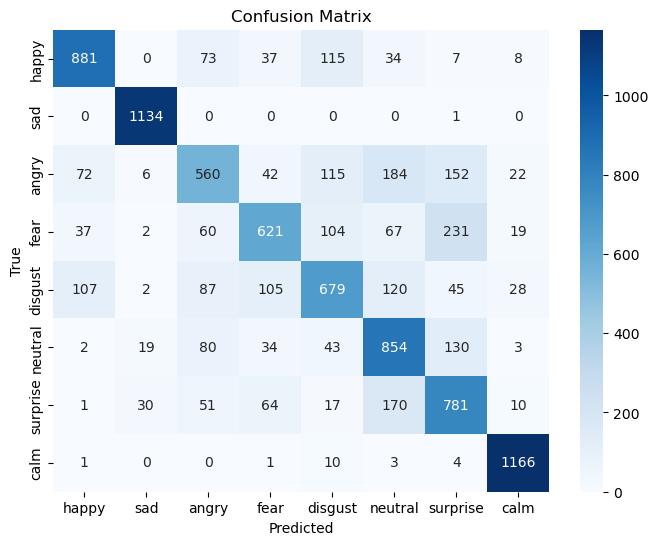

              precision    recall  f1-score   support

       happy       0.80      0.76      0.78      1155
         sad       0.95      1.00      0.97      1135
       angry       0.61      0.49      0.54      1153
        fear       0.69      0.54      0.61      1141
     disgust       0.63      0.58      0.60      1173
     neutral       0.60      0.73      0.66      1165
    surprise       0.58      0.69      0.63      1124
        calm       0.93      0.98      0.96      1185

    accuracy                           0.72      9231
   macro avg       0.72      0.72      0.72      9231
weighted avg       0.72      0.72      0.72      9231



In [27]:
from sklearn.metrics import classification_report, confusion_matrix

emotions = ['happy','sad','angry','fear','disgust','neutral','surprise','calm']

predictions = model.predict(x_test)

y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

target_names = emotions

print(classification_report(y_true, y_pred, target_names=target_names))

In [28]:
model.save('emotionsonic.h5')